# BM25 с BPE токенизацией

Улучшаем BM25 бейзлайн с помощью SentencePiece BPE токенизации.

In [1]:
!pip install pyarrow==18.1.0 -q
!pip install datasets==2.14.0 sentence-transformers sentencepiece faiss-cpu rank-bm25 pymorphy2 torch tqdm -q
!pip install huggingface_hub -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 101.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 120.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 11.6 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import json
import gzip
import pickle
import random
import requests
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm.notebook import tqdm
from huggingface_hub import hf_hub_download, list_repo_files
import sentencepiece as spm
import gc
import time
from rank_bm25 import BM25Okapi

random.seed(42)
np.random.seed(42)

## 1. Загрузка данных

In [3]:
BASE_URL = "https://huggingface.co/datasets/miracl/miracl/resolve/main/miracl-v1.0-ru/"

def load_queries(split: str) -> dict:
    url = f"{BASE_URL}topics/topics.miracl-v1.0-ru-{split}.tsv"
    try:
        response = requests.get(url, timeout=60)
        response.raise_for_status()
        queries = {}
        for line in response.text.strip().split('\n')[1:]:
            parts = line.split('\t')
            if len(parts) >= 2:
                queries[parts[0]] = parts[1]
        return queries
    except:
        return {}

def load_qrels(split: str) -> dict:
    url = f"{BASE_URL}qrels/qrels.miracl-v1.0-ru-{split}.tsv"
    try:
        response = requests.get(url, timeout=60)
        response.raise_for_status()
        qrels = defaultdict(lambda: {'positive': [], 'negative': []})
        for line in response.text.strip().split('\n'):
            parts = line.split('\t')
            if len(parts) >= 4:
                qid, doc_id, rel = parts[0], parts[2], int(parts[3])
                key = 'positive' if rel > 0 else 'negative'
                qrels[qid][key].append(doc_id)
        return dict(qrels)
    except:
        return {}

def get_required_doc_ids(qrels_dict: dict) -> set:
    doc_ids = set()
    for q in qrels_dict.values():
        doc_ids.update(q.get('positive', []))
        doc_ids.update(q.get('negative', []))
    return doc_ids

In [4]:
dev_queries = load_queries('dev')
dev_qrels = load_qrels('dev')
train_queries = load_queries('train')
train_qrels = load_qrels('train')

test_a_queries = load_queries('test-a')
test_b_queries = load_queries('test-b')
test_queries = {**test_a_queries, **test_b_queries}

all_qrels = {**dev_qrels, **train_qrels}
required_doc_ids = get_required_doc_ids(all_qrels)

print(f"Dev: {len(dev_queries)} запросов")
print(f"Train: {len(train_queries)} запросов")
print(f"Документов в qrels: {len(required_doc_ids)}")

Dev: 1251 запросов
Train: 4682 запросов
Документов в qrels: 41007


In [5]:
def load_corpus(target_docs: int = 500_000, seed: int = 42) -> tuple:
    random.seed(seed)

    all_files = list_repo_files("miracl/miracl-corpus", repo_type="dataset")
    jsonl_files = sorted([f for f in all_files if 'ru' in f and f.endswith('.jsonl.gz')])
    docs_per_file = target_docs // len(jsonl_files)

    corpus = {}
    doc_ids = []
    passages = []

    for jsonl_file in tqdm(jsonl_files, desc="Загрузка корпуса"):
        try:
            file_path = hf_hub_download(
                repo_id="miracl/miracl-corpus",
                filename=jsonl_file,
                repo_type="dataset"
            )

            file_docs = []
            required_docs = []

            with gzip.open(file_path, 'rt', encoding='utf-8') as f:
                for line in f:
                    if not line.strip():
                        continue
                    item = json.loads(line)
                    doc = {
                        'docid': item['docid'],
                        'title': item['title'],
                        'text': item['text'],
                        'full_text': f"{item['title']}. {item['text']}"
                    }

                    if item['docid'] in required_doc_ids:
                        required_docs.append(doc)
                    else:
                        file_docs.append(doc)

            sample_size = min(docs_per_file, len(file_docs))
            selected = random.sample(file_docs, sample_size) if file_docs else []
            all_selected = selected + required_docs

            for doc in all_selected:
                if doc['docid'] not in corpus:
                    corpus[doc['docid']] = {
                        'title': doc['title'],
                        'text': doc['text'],
                        'full_text': doc['full_text']
                    }
                    doc_ids.append(doc['docid'])
                    passages.append(doc['full_text'])

        except Exception as e:
            print(f"Ошибка: {e}")
            continue

    return corpus, doc_ids, passages

corpus, doc_ids, passages = load_corpus(target_docs=500_000)
print(f"Загружено документов: {len(corpus):,}")

Загрузка корпуса:   0%|          | 0/20 [00:00<?, ?it/s]

miracl-corpus-v1.0-ru/docs-0.jsonl.gz:   0%|          | 0.00/100M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-1.jsonl.gz:   0%|          | 0.00/98.0M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-10.jsonl.gz:   0%|          | 0.00/75.7M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-11.jsonl.gz:   0%|          | 0.00/78.3M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-12.jsonl.gz:   0%|          | 0.00/76.5M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-13.jsonl.gz:   0%|          | 0.00/78.2M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-14.jsonl.gz:   0%|          | 0.00/78.3M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-15.jsonl.gz:   0%|          | 0.00/79.4M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-16.jsonl.gz:   0%|          | 0.00/81.4M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-17.jsonl.gz:   0%|          | 0.00/82.0M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-18.jsonl.gz:   0%|          | 0.00/81.0M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-19.jsonl.gz:   0%|          | 0.00/6.75M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-2.jsonl.gz:   0%|          | 0.00/90.1M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-3.jsonl.gz:   0%|          | 0.00/89.4M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-4.jsonl.gz:   0%|          | 0.00/82.0M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-5.jsonl.gz:   0%|          | 0.00/88.5M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-6.jsonl.gz:   0%|          | 0.00/81.1M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-7.jsonl.gz:   0%|          | 0.00/80.2M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-8.jsonl.gz:   0%|          | 0.00/74.5M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-9.jsonl.gz:   0%|          | 0.00/73.5M [00:00<?, ?B/s]

Загружено документов: 541,007


## 2. Обучение BPE токенизатора

In [6]:
VOCAB_SIZE = 25000
MODEL_PREFIX = "bpe_ru_25k"

# Сохраняем тексты во временный файл
temp_file = "temp_corpus.txt"
with open(temp_file, "w", encoding="utf-8") as f:
    for passage in tqdm(passages, desc="Подготовка"):
        clean_text = passage.replace("\n", " ").strip()
        if clean_text:
            f.write(clean_text + "\n")

print(f"Размер файла: {os.path.getsize(temp_file) / 1024 / 1024:.1f} MB")

Подготовка:   0%|          | 0/541007 [00:00<?, ?it/s]

Размер файла: 338.0 MB


In [7]:
print(f"Обучение BPE (vocab_size={VOCAB_SIZE:,})...")
start_time = time.time()

spm.SentencePieceTrainer.train(
    input=temp_file,
    model_prefix=MODEL_PREFIX,
    vocab_size=VOCAB_SIZE,
    model_type="bpe",
    normalization_rule_name="nmt_nfkc_cf",
    pad_id=0, unk_id=1, bos_id=2, eos_id=3,
    character_coverage=0.9995,
    num_threads=os.cpu_count(),
    max_sentence_length=4192,
    shuffle_input_sentence=True,
)

print(f"Время обучения: {time.time() - start_time:.1f} сек")
os.remove(temp_file)

Обучение BPE (vocab_size=25,000)...
Время обучения: 349.6 сек


## 3. Тестирование токенизатора

In [8]:
sp = spm.SentencePieceProcessor()
sp.load(f"{MODEL_PREFIX}.model")

print(f"Размер словаря: {sp.get_piece_size():,} токенов\n")

test_texts = [
    "Юрий Гагарин — первый космонавт в мире",
    "Москва — столица Российской Федерации",
    "Кто написал роман Война и мир?",
]

for text in test_texts:
    tokens = sp.encode_as_pieces(text)
    print(f"Текст: {text}")
    print(f"Токены ({len(tokens)}): {tokens}\n")

Размер словаря: 25,000 токенов

Текст: Юрий Гагарин — первый космонавт в мире
Токены (9): ['▁юрий', '▁гага', 'рин', '▁—', '▁первый', '▁космонав', 'т', '▁в', '▁мире']

Текст: Москва — столица Российской Федерации
Токены (5): ['▁москва', '▁—', '▁столица', '▁российской', '▁федерации']

Текст: Кто написал роман Война и мир?
Токены (7): ['▁кто', '▁написал', '▁роман', '▁война', '▁и', '▁мир', '?']



## 4. BM25 с BPE токенизацией

In [9]:
class BM25_BPE:
    def __init__(self, model_path: str):
        self.sp = spm.SentencePieceProcessor()
        self.sp.load(model_path)
        self.bm25 = None
        self.doc_ids = None
        self.passages = None
        self.min_token_len = 2

    def tokenize(self, text: str) -> list:
        tokens = self.sp.encode_as_pieces(text)
        filtered = []
        for token in tokens:
            clean_token = token.replace("▁", "")
            if len(clean_token) < self.min_token_len:
                continue
            if clean_token in '.,!?;:—–-()[]{}«»"\'':
                continue
            filtered.append(token)
        return filtered

    def fit(self, doc_ids: list, passages: list):
        self.doc_ids = doc_ids
        self.passages = passages

        tokenized_corpus = []
        for passage in tqdm(passages, desc="Токенизация"):
            tokens = self.tokenize(passage)
            tokenized_corpus.append(tokens)

        self.bm25 = BM25Okapi(tokenized_corpus)
        del tokenized_corpus
        gc.collect()

        print(f"Индекс построен: {len(doc_ids):,} документов")

    def search(self, query: str, top_k: int = 10) -> list:
        query_tokens = self.tokenize(query)
        scores = self.bm25.get_scores(query_tokens)
        top_indices = np.argsort(scores)[::-1][:top_k]

        results = []
        for idx in top_indices:
            results.append({
                'doc_id': self.doc_ids[idx],
                'score': float(scores[idx]),
                'passage': self.passages[idx]
            })
        return results

    def get_query_tokens(self, query: str) -> list:
        return self.tokenize(query)

In [10]:
gc.collect()

bm25_bpe = BM25_BPE(f"{MODEL_PREFIX}.model")

start_time = time.time()
bm25_bpe.fit(doc_ids, passages)
print(f"Время построения: {time.time() - start_time:.1f} сек")

Токенизация:   0%|          | 0/541007 [00:00<?, ?it/s]

Индекс построен: 541,007 документов
Время построения: 323.0 сек


## 5. Тестирование поиска

In [11]:
test_questions = [
    "Кто такой Юрий Гагарин?",
    "Столица России",
    "Кто написал Войну и мир?"
]

for question in test_questions:
    print(f"\n{question}")
    tokens = bm25_bpe.get_query_tokens(question)
    print(f"Токены: {tokens}")

    result = bm25_bpe.search(question, top_k=1)[0]
    print(f"Ответ: {result['passage'][:120]}...")


Кто такой Юрий Гагарин?
Токены: ['▁кто', '▁такой', '▁юрий', '▁гага', 'рин']
Ответ: Гагарин, Юрий Алексеевич. 12 апреля 1961 года Юрий Гагарин стал первым человеком в мировой истории, совершившим полёт в ...

Столица России
Токены: ['▁столица', '▁россии']
Ответ: Столицы России. В 1712 году по воле Петра I столица России была перенесена в Санкт-Петербург, специально основанный как ...

Кто написал Войну и мир?
Токены: ['▁кто', '▁написал', '▁войну', '▁мир']
Ответ: Эванс, Эллис Хамфри. Э́ллис Ха́мфри Э́ванс, более известный под бардическим именем Хед Вин или Хедд Вин ( 'белый мир', т...


## 6. Оценка качества

In [12]:
def evaluate_retriever(retriever, queries: dict, qrels: dict, k_values: list = [1, 5, 10, 20, 100]) -> dict:
    metrics = defaultdict(list)
    indexed_docs = set(retriever.doc_ids)

    for qid, query_text in tqdm(queries.items(), desc="Оценка"):
        if qid not in qrels:
            continue

        relevant = [d for d in qrels[qid]['positive'] if d in indexed_docs]
        if not relevant:
            continue

        results = retriever.search(query_text, top_k=max(k_values))
        retrieved = [r['doc_id'] for r in results]

        for k in k_values:
            hit = len(set(retrieved[:k]) & set(relevant))
            metrics[f'Recall@{k}'].append(hit / len(relevant))

        mrr = 0.0
        for rank, doc_id in enumerate(retrieved, 1):
            if doc_id in set(relevant):
                mrr = 1.0 / rank
                break
        metrics['MRR'].append(mrr)

        rel_set = set(relevant)
        dcg = sum(1.0/np.log2(i+2) for i, d in enumerate(retrieved[:10]) if d in rel_set)
        idcg = sum(1.0/np.log2(i+2) for i in range(min(10, len(relevant))))
        metrics['NDCG@10'].append(dcg / idcg if idcg > 0 else 0)

    return {k: np.mean(v) for k, v in metrics.items()}

In [13]:
bpe_dev_metrics = evaluate_retriever(bm25_bpe, dev_queries, dev_qrels)

print("Результаты BM25+BPE (dev):")
print("-" * 30)
for metric, value in sorted(bpe_dev_metrics.items()):
    print(f"{metric}: {value:.4f}")

Оценка:   0%|          | 0/1251 [00:00<?, ?it/s]

Результаты BM25+BPE (dev):
------------------------------
MRR: 0.4297
NDCG@10: 0.3569
Recall@1: 0.1444
Recall@10: 0.4501
Recall@100: 0.7305
Recall@20: 0.5553
Recall@5: 0.3381


In [14]:
# Загрузка baseline метрик
baseline_metrics = {}
if os.path.exists('miracl_data.pkl'):
    with open('miracl_data.pkl', 'rb') as f:
        data = pickle.load(f)
        baseline_metrics = data.get('baseline_metrics', {})
    print("Baseline метрики загружены")
else:
    print("Файл miracl_data.pkl не найден")

Baseline метрики загружены


In [15]:
import pandas as pd

comparison = []
for metric in ['MRR', 'Recall@1', 'Recall@5', 'Recall@10', 'Recall@100', 'NDCG@10']:
    baseline_val = baseline_metrics.get(metric, 0)
    bpe_val = bpe_dev_metrics.get(metric, 0)
    diff = bpe_val - baseline_val

    comparison.append({
        'Метрика': metric,
        'Baseline': f"{baseline_val:.4f}",
        'BM25+BPE': f"{bpe_val:.4f}",
        'Δ': f"{diff:+.4f}"
    })

df = pd.DataFrame(comparison)
print(df.to_string(index=False))

   Метрика Baseline BM25+BPE       Δ
       MRR   0.3855   0.4297 +0.0442
  Recall@1   0.1301   0.1444 +0.0143
  Recall@5   0.2883   0.3381 +0.0498
 Recall@10   0.3747   0.4501 +0.0754
Recall@100   0.6052   0.7305 +0.1253
   NDCG@10   0.3072   0.3569 +0.0496


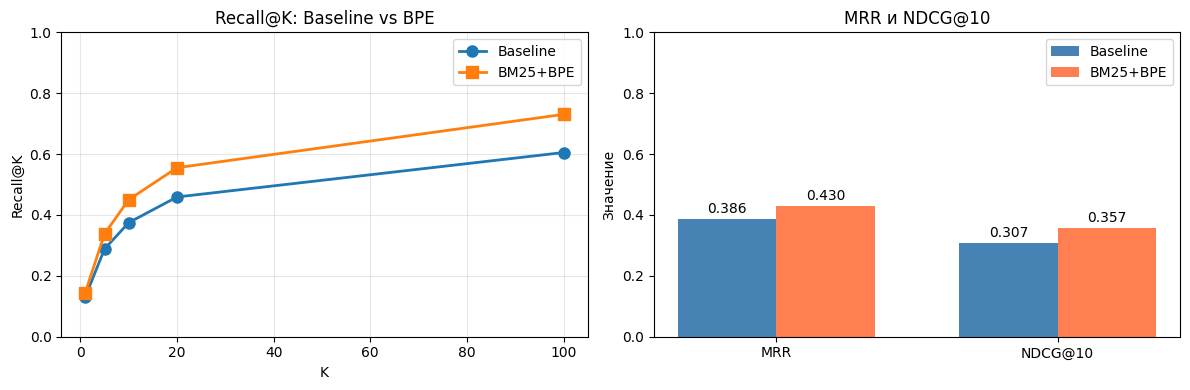

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Recall@K
k_values = [1, 5, 10, 20, 100]
baseline_recalls = [baseline_metrics.get(f'Recall@{k}', 0) for k in k_values]
bpe_recalls = [bpe_dev_metrics.get(f'Recall@{k}', 0) for k in k_values]

axes[0].plot(k_values, baseline_recalls, 'o-', label='Baseline', linewidth=2, markersize=8)
axes[0].plot(k_values, bpe_recalls, 's-', label='BM25+BPE', linewidth=2, markersize=8)
axes[0].set_xlabel('K')
axes[0].set_ylabel('Recall@K')
axes[0].set_title('Recall@K: Baseline vs BPE')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0, 1)

# MRR и NDCG
metrics_names = ['MRR', 'NDCG@10']
baseline_vals = [baseline_metrics.get(m, 0) for m in metrics_names]
bpe_vals = [bpe_dev_metrics.get(m, 0) for m in metrics_names]

x = np.arange(len(metrics_names))
width = 0.35

bars1 = axes[1].bar(x - width/2, baseline_vals, width, label='Baseline', color='steelblue')
bars2 = axes[1].bar(x + width/2, bpe_vals, width, label='BM25+BPE', color='coral')
axes[1].set_ylabel('Значение')
axes[1].set_title('MRR и NDCG@10')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics_names)
axes[1].legend()
axes[1].set_ylim(0, 1)

for bar, val in zip(bars1, baseline_vals):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{val:.3f}', ha='center')
for bar, val in zip(bars2, bpe_vals):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{val:.3f}', ha='center')

plt.tight_layout()
plt.savefig('baseline_vs_bpe.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Сохранение результатов

In [17]:
results = {
    'vocab_size': VOCAB_SIZE,
    'model_file': f"{MODEL_PREFIX}.model",
    'corpus_size': len(corpus),
    'metrics': bpe_dev_metrics,
    'comparison': {
        'baseline_mrr': baseline_metrics.get('MRR', 0),
        'bpe_mrr': bpe_dev_metrics['MRR'],
        'improvement': bpe_dev_metrics['MRR'] - baseline_metrics.get('MRR', 0)
    }
}

with open('bm25_bpe_results.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

print("Результаты сохранены: bm25_bpe_results.json")

Результаты сохранены: bm25_bpe_results.json


In [18]:
print(f"""
Итоги BM25 + BPE:

Конфигурация:
  Словарь: {VOCAB_SIZE:,} токенов
  Документов: {len(corpus):,}

Результаты (dev):
  MRR:       {bpe_dev_metrics['MRR']:.4f} (baseline: {baseline_metrics.get('MRR', 0):.4f})
  Recall@10: {bpe_dev_metrics['Recall@10']:.4f} (baseline: {baseline_metrics.get('Recall@10', 0):.4f})
  NDCG@10:   {bpe_dev_metrics['NDCG@10']:.4f} (baseline: {baseline_metrics.get('NDCG@10', 0):.4f})

Файлы:
  {MODEL_PREFIX}.model - BPE токенизатор
  baseline_vs_bpe.png - график сравнения
""")


Итоги BM25 + BPE:

Конфигурация:
  Словарь: 25,000 токенов
  Документов: 541,007

Результаты (dev):
  MRR:       0.4297 (baseline: 0.3855)
  Recall@10: 0.4501 (baseline: 0.3747)
  NDCG@10:   0.3569 (baseline: 0.3072)

Файлы:
  bpe_ru_25k.model - BPE токенизатор
  baseline_vs_bpe.png - график сравнения

